<a href="https://colab.research.google.com/github/wedexyz/eeg-/blob/main/CNN%2BReduceLe%2BCrossVall%2BROcVS2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [293]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [294]:
pip install sklearn


In [295]:
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM, BatchNormalization, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
import pandas as pd
import os
import random
import time
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping
#from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

from scipy import signal
from scipy.fft import fftshift

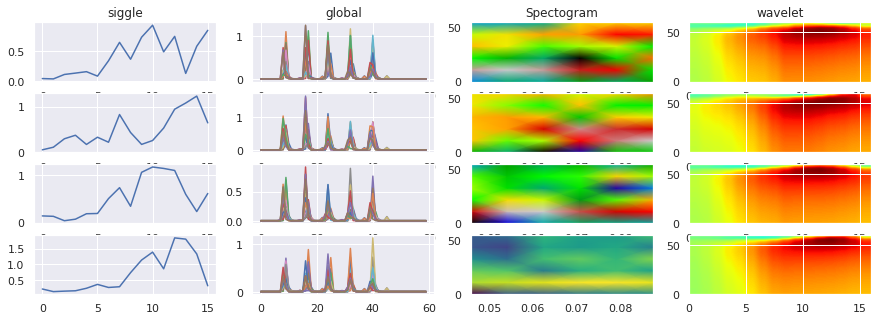

In [296]:
idle = np.load("/content/drive/My Drive/Colab Notebooks/data_baru/idle/1604315006.npy")
kanan = np.load("/content/drive/My Drive/Colab Notebooks/data_baru/kanan/1604315180.npy")
kiri = np.load("/content/drive/My Drive/Colab Notebooks/data_baru/kiri/1604315126.npy")
maju = np.load("/content/drive/My Drive/Colab Notebooks/data_baru/maju/1604315069.npy")

kelas1=idle[0][16]
kelas2=maju[0][16]
kelas3=kanan[0][16]
kelas4=kiri[0][16]

kelas1a=idle[175]
kelas2a=maju[175]
kelas3a=kanan[175]
kelas4a=kiri[175]

#print(idlea.shape)


f1, t1,Sxx= signal.spectrogram(kelas1,fs=120, window=('tukey', 0.25),
                             nperseg=11,
                             noverlap=10,
                             nfft=None, 
                             detrend='constant',
                             return_onesided=True, 
                             scaling='density', 
                             axis=-1,
                             mode='psd'
                            )
dbs1 = 10*np.log10(Sxx)
f2, t2,Sxx= signal.spectrogram(kelas2,fs=120, window=('tukey', 0.25),
                             nperseg=11,
                             noverlap=10,
                             nfft=None, 
                             detrend='constant',
                             return_onesided=True, 
                             scaling='density', 
                             axis=-1,
                             mode='psd',
                            )
dbs2 = 10*np.log10(Sxx)
f3, t3,Sxx= signal.spectrogram(kelas3,fs=120, window=('tukey', 0.25),
                             nperseg=11,
                             noverlap=10,
                             nfft=None, 
                             detrend='constant',
                             return_onesided=True, 
                             scaling='density', 
                             axis=-1,
                             mode='psd'
                            )
dbs3 = 10*np.log10(Sxx)
f4, t4,Sxx= signal.spectrogram(kelas4,fs=120, window=('tukey', 0.25),
                             nperseg=11,
                             noverlap=10,
                             nfft=None, 
                             detrend='constant',
                             return_onesided=True, 
                             scaling='density', 
                             axis=-1,
                             mode='psd'
                            )  
dbs4 = 10*np.log10(Sxx)



fig, axs = plt.subplots(nrows=4, ncols=4)
axs = axs.flatten()

axs[0].set_title("siggle")
axs[0].plot(kelas1)

axs[1].set_title("global")
axs[1].plot(kelas1a)

axs[2].set_title("Spectogram")
axs[2].pcolormesh(t1, f1,dbs1,  
                  shading='gouraud',
                  cmap='nipy_spectral')

cwt1 = signal.cwt(kelas1,signal.ricker,widths=np.arange(1,50))
cwt2 = signal.cwt(kelas2,signal.ricker,widths=np.arange(1,50))
cwt3 = signal.cwt(kelas3,signal.ricker,widths=np.arange(1,50))
cwt4 = signal.cwt(kelas4,signal.ricker,widths=np.arange(1,50))
axs[3].set_title("wavelet")
axs[3].imshow(cwt1,extent=[0,16,0,60],cmap='jet',aspect='auto',vmax=abs(cwt1).max(),vmin=-abs(cwt1).max())

axs[4].plot(kelas2)
axs[5].plot(kelas2a)
axs[6].pcolormesh(t2, f2,dbs2,  
                  shading='gouraud',
                  cmap='nipy_spectral')
axs[7].imshow(cwt2,extent=[0,16,0,60],cmap='jet',aspect='auto',vmax=abs(cwt2).max(),vmin=-abs(cwt2).max())

axs[8].plot(kelas3)
axs[9].plot(kelas3a)
axs[10].pcolormesh(t3, f3,dbs3,  
                  shading='gouraud',
                  cmap='nipy_spectral')
axs[11].imshow(cwt3,extent=[0,16,0,60],cmap='jet',aspect='auto',vmax=abs(cwt3).max(),vmin=-abs(cwt3).max())

axs[12].plot(kelas4)
axs[13].plot(kelas4a)
axs[14].pcolormesh(t4, f4,dbs4,  
                  shading='gouraud',
                  cmap='viridis')
axs[15].imshow(cwt4,extent=[0,16,0,60],cmap='jet',aspect='auto',vmax=abs(cwt4).max(),vmin=-abs(cwt4).max())
plt.show()


In [297]:
ACTIONS = ["kiri", "maju","idle","kanan"]
reshape = (-1,16, 60,1)
#reshape(-1,28,28,1)




In [298]:
def create_data(starting_dir="=/content/drive/My Drive/Colab Notebooks/data_baru"):
    training_data = {}
    for action in ACTIONS:
        if action not in training_data:
            training_data[action] = []
        data_dir = os.path.join(starting_dir,action)
        for item in os.listdir(data_dir):
            data = np.load(os.path.join(data_dir, item))
            for item in data:
                training_data[action].append(item)

    lengths = [len(training_data[action]) for action in ACTIONS]
    print(lengths)

    for action in ACTIONS:
        np.random.shuffle(training_data[action])  
        training_data[action] = training_data[action][:min(lengths)]

    lengths = [len(training_data[action]) for action in ACTIONS]
    print(lengths)
    combined_data = []
    for action in ACTIONS:
        for data in training_data[action]:
            if action == "kiri":
                combined_data.append([data, [1, 0, 0,0]])
            elif action == "maju":
                combined_data.append([data, [0, 1, 0, 0]])
            elif action == "idle":
                combined_data.append([data, [0, 0, 1, 0]])
            elif action == "kanan":
                combined_data.append([data, [0, 0, 0, 1]])

    np.random.shuffle(combined_data)
    print("length:",len(combined_data))
    return combined_data

In [299]:
print("creating training data")
traindata = create_data(starting_dir="/content/drive/My Drive/Colab Notebooks/data_baru")
train_X = []
train_y = []
for X, y in traindata:
    train_X.append(X)
    train_y.append(y)



creating training data
[1000, 1000, 1000, 1000]
[1000, 1000, 1000, 1000]
length: 4000


In [300]:
print("creating testing data")
testdata = create_data(starting_dir="/content/drive/MyDrive/Colab Notebooks/tes_data")
test_X = []
test_y = []

for X, y in testdata:
    test_X.append(X)
    test_y.append(y)
train_X = np.array(train_X).reshape(reshape)
test_X = np.array(test_X).reshape(reshape)

train_y = np.array(train_y)
test_y = np.array(test_y)



creating testing data
[250, 250, 250, 250]
[250, 250, 250, 250]
length: 1000


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


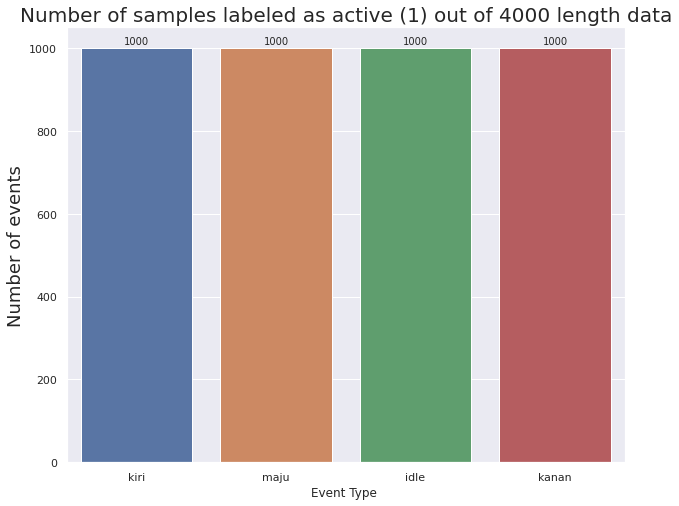

In [301]:

import seaborn as sns
ye=pd.DataFrame(train_y)

ye.columns=["kiri", "maju","idle","kanan"]
categories = list(ye.columns.values)
sns.set(font_scale = 1)
plt.figure(figsize=(10,8))
ax= sns.barplot(categories, ye.iloc[:,0:].sum().values)
plt.title("Number of samples labeled as active (1) out of {0} length data".format((ye.shape[0])),fontsize=20)

plt.ylabel('Number of events', fontsize=18)
plt.xlabel('Event Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = ye.iloc[:,0:].sum().values

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=10)
plt.show()

In [302]:
# With data augmentation to prevent overfitting
'''
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_X)
'''

'\ndatagen = ImageDataGenerator(\n        featurewise_center=False,  # set input mean to 0 over the dataset\n        samplewise_center=False,  # set each sample mean to 0\n        featurewise_std_normalization=False,  # divide inputs by std of the dataset\n        samplewise_std_normalization=False,  # divide each input by its std\n        zca_whitening=False,  # apply ZCA whitening\n        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)\n        zoom_range = 0.1, # Randomly zoom image \n        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)\n        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)\n        horizontal_flip=False,  # randomly flip images\n        vertical_flip=False)  # randomly flip images\n\n\ndatagen.fit(train_X)\n'

In [303]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1,factor=0.5, min_lr=0.0001)

In [304]:
#def cnn_model(size, num_cnn_layers):
def cnn_model():    

    model = Sequential()
    
    model.add(Conv2D(filters = 64, kernel_size = (7,7), padding = "same", activation = "relu", input_shape=train_X.shape[1:]))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv2D(filters = 64, kernel_size = (5,5), padding = "same", activation = "relu",input_shape=train_X.shape[1:]))
    model.add(MaxPooling2D(pool_size = (5,5)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "same", activation = "relu",input_shape=train_X.shape[1:]))
    model.add(MaxPooling2D(pool_size = (3,3)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Flatten())
    
    model.add(Dense(32, activation = "relu"))
    model.add(BatchNormalization())

    model.add(Dense(4, activation = "sigmoid"))
   
    #adam = Adam(lr = 0.001)
    model.compile(optimizer ="adam", loss = "binary_crossentropy", metrics = ['accuracy'])
    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 
    
    return model


In [305]:
#model = cnn_model(IMAGE_SIZE, 2)
model = cnn_model()
model.summary()

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_164 (Conv2D)          (None, 16, 60, 64)        3200      
_________________________________________________________________
batch_normalization_217 (Bat (None, 16, 60, 64)        256       
_________________________________________________________________
dropout_163 (Dropout)        (None, 16, 60, 64)        0         
_________________________________________________________________
conv2d_165 (Conv2D)          (None, 16, 60, 64)        102464    
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 3, 12, 64)         0         
_________________________________________________________________
dropout_164 (Dropout)        (None, 3, 12, 64)         0         
_________________________________________________________________
batch_normalization_218 (Bat (None, 3, 12, 64)       

In [306]:
#set early stopping criteria
pat = 5
#this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('subjek1.h5', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=100, BATCH_SIZE=32):
    model = None
    #model = cnn_model(IMAGE_SIZE, 2)
    model = cnn_model()
    #Model = model
   # results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], 
   #           verbose=1, validation_split=0.1) 
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[learning_rate_reduction,early_stopping, model_checkpoint], 
              verbose=1, validation_split=0.1)   
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

In [307]:
n_folds=5
epochs=100
batch_size=32

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(train_X, train_y, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
   
    print("======="*12, end="\n\n\n")


Training on Fold:  1
Epoch 1/100
102/102 [==============================] - 2s 12ms/step - loss: 0.7677 - accuracy: 0.2668 - val_loss: 0.6985 - val_accuracy: 0.2694

Epoch 00001: val_loss improved from inf to 0.69850, saving model to subjek1.h5
Epoch 2/100
102/102 [==============================] - 1s 10ms/step - loss: 0.6354 - accuracy: 0.2546 - val_loss: 0.6085 - val_accuracy: 0.2083

Epoch 00002: val_loss improved from 0.69850 to 0.60846, saving model to subjek1.h5
Epoch 3/100
102/102 [==============================] - 1s 10ms/step - loss: 0.5834 - accuracy: 0.2766 - val_loss: 0.5817 - val_accuracy: 0.2667

Epoch 00003: val_loss improved from 0.60846 to 0.58172, saving model to subjek1.h5
Epoch 4/100
102/102 [==============================] - 1s 10ms/step - loss: 0.5666 - accuracy: 0.2931 - val_loss: 0.5680 - val_accuracy: 0.2361

Epoch 00004: val_loss improved from 0.58172 to 0.56804, saving model to subjek1.h5
Epoch 5/100
102/102 [==============================] - 1s 13ms/step - l

In [308]:
#Load the model that was saved by ModelCheckpoint
model = load_model('subjek1.h5')

In [309]:
model.evaluate(test_X, test_y)
#print("Accuracy of the model is - " , model.evaluate(test_X,test_y)[1]*100 , "%")
#plt.bar( model.evaluate(test_X)[1].index,  model.evaluate(test_y)[1])


32/32 [==============================] - 0s 3ms/step - loss: 0.1505 - accuracy: 0.8220


[0.15046069025993347, 0.8220000267028809]

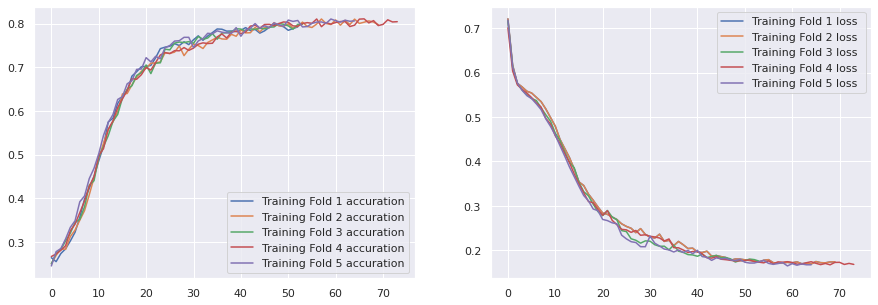

In [310]:
fig, (ax1, ax2) =  plt.subplots( ncols=2, sharex=True)

ax1.plot(model_history[0].history['accuracy'], label='Training Fold 1 accuration')
ax1.plot(model_history[1].history['accuracy'], label='Training Fold 2 accuration')
ax1.plot(model_history[2].history['accuracy'], label='Training Fold 3 accuration')
ax1.plot(model_history[3].history['accuracy'], label='Training Fold 4 accuration')
ax1.plot(model_history[4].history['accuracy'], label='Training Fold 5 accuration')
ax1.legend()
ax2.plot(model_history[1].history['loss'], label='Training Fold 1 loss')
ax2.plot(model_history[1].history['loss'], label='Training Fold 2 loss')
ax2.plot(model_history[2].history['loss'], label='Training Fold 3 loss')
ax2.plot(model_history[3].history['loss'], label='Training Fold 4 loss ')
ax2.plot(model_history[4].history['loss'], label='Training Fold 5 loss')
ax2.legend()
plt.show()

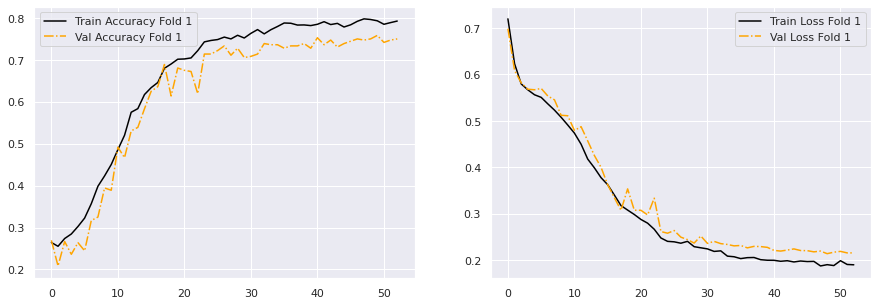

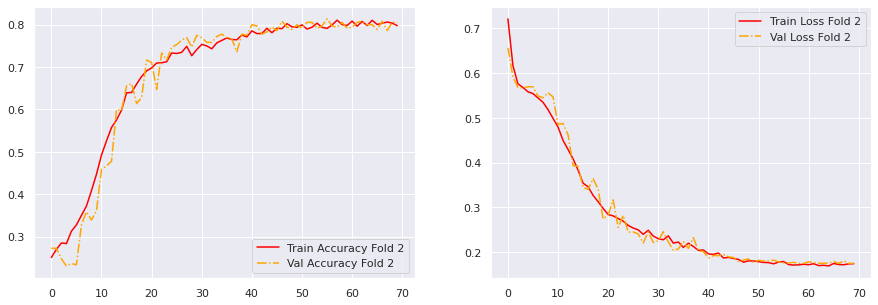

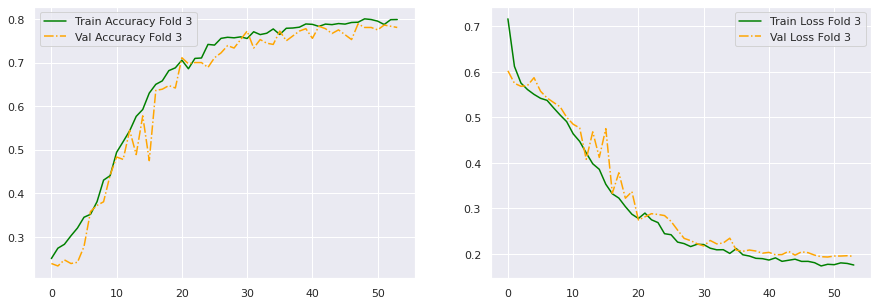

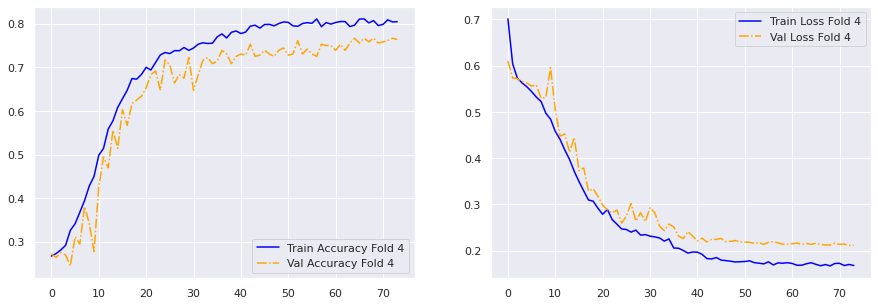

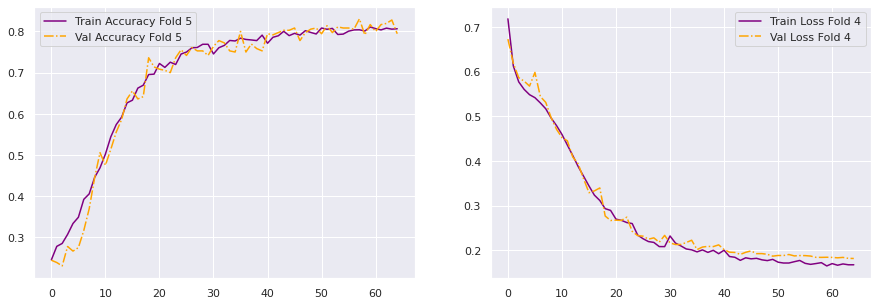

In [311]:

fig, (plt1, plt2)  =  plt.subplots( ncols=2, sharex=True)
plt1.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt1.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='orange', linestyle = "dashdot")
plt1.legend()
plt2.plot(model_history[0].history['loss'], label='Train Loss Fold 1', color='black')
plt2.plot(model_history[0].history['val_loss'], label='Val Loss Fold 1', color='orange', linestyle = "dashdot")
plt2.legend()
plt.show()

fig, (plt1, plt2)  =  plt.subplots( ncols=2, sharex=True)
plt1.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red')
plt1.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='orange', linestyle = "dashdot")
plt1.legend()
plt2.plot(model_history[1].history['loss'], label='Train Loss Fold 2', color='red')
plt2.plot(model_history[1].history['val_loss'], label='Val Loss Fold 2', color='orange', linestyle = "dashdot")
plt2.legend()
plt.show()

fig, (plt1, plt2)  =  plt.subplots( ncols=2, sharex=True)
plt1.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green')
plt1.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='orange', linestyle = "dashdot")
plt1.legend()
plt2.plot(model_history[2].history['loss'], label='Train Loss Fold 3', color='green')
plt2.plot(model_history[2].history['val_loss'], label='Val Loss Fold 3', color='orange', linestyle = "dashdot")
plt2.legend()
plt.show()


fig, (plt1, plt2)  =  plt.subplots( ncols=2, sharex=True)
plt1.plot(model_history[3].history['accuracy'], label='Train Accuracy Fold 4', color='blue')
plt1.plot(model_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='orange', linestyle = "dashdot")
plt1.legend()
plt2.plot(model_history[3].history['loss'], label='Train Loss Fold 4', color='blue')
plt2.plot(model_history[3].history['val_loss'], label='Val Loss Fold 4', color='orange', linestyle = "dashdot")
plt2.legend()
plt.show()

fig, (plt1, plt2)  =  plt.subplots( ncols=2, sharex=True)
plt1.plot(model_history[4].history['accuracy'], label='Train Accuracy Fold 5', color='purple')
plt1.plot(model_history[4].history['val_accuracy'], label='Val Accuracy Fold 5', color='orange', linestyle = "dashdot")
plt1.legend()
plt2.plot(model_history[4].history['loss'], label='Train Loss Fold 4', color='purple')
plt2.plot(model_history[4].history['val_loss'], label='Val Loss Fold 4', color='orange', linestyle = "dashdot")
plt2.legend()
plt.show()

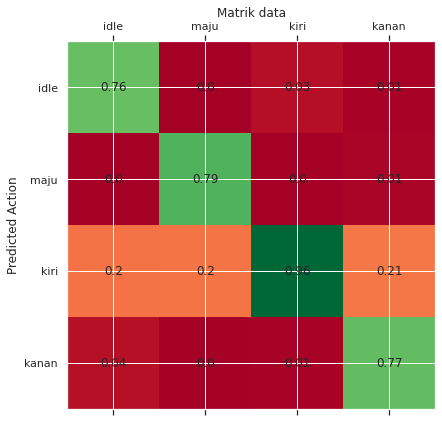

In [312]:

MODEL_NAME ='/content/subjek1.h5' 

#CLIP = True # if your model was trained with np.clip to clip  values
CLIP = False
CLIP_VAL = 8  # if above, what was the value +/-

model = tf.keras.models.load_model(MODEL_NAME)

VALDIR = '/content/drive/MyDrive/Colab Notebooks/tes_data'
ACTIONS =  ["idle","maju","kiri", "kanan"]
PRED_BATCH = 32


def get_val_data(valdir, action, batch_size):

   # argmax_dict = {0: 0, 1: 0, 2: 0,3:0}
    argmax_dict = {2: 0, 0: 0, 1: 0,3:0}
    raw_pred_dict = {0: 0, 1: 0, 2: 0,3:0}

    action_dir = os.path.join(valdir, action)
    for session_file in os.listdir(action_dir):
        filepath = os.path.join(action_dir,session_file)
        if CLIP:
            data = np.clip(np.load(filepath), -CLIP_VAL, CLIP_VAL) / CLIP_VAL
            #print(data)
        else:
            data = np.load(filepath) 
        preds = model.predict([data.reshape(-1, 16, 60,1)], batch_size=batch_size)
        
        for pred in preds:
            argmax = np.argmax(pred)
            argmax_dict[argmax] += 1
            for idx,value in enumerate(pred):
                raw_pred_dict[idx] += value
    
    argmax_pct_dict = {}
    for i in argmax_dict:
        total = 0
        correct = argmax_dict[i]
        for ii in argmax_dict:
            total += argmax_dict[ii]
        argmax_pct_dict[i] = round(correct/total, 4)
    return argmax_dict, raw_pred_dict, argmax_pct_dict


def make_conf_mat(none,left,forward, right):
    action_dict = {"idle":none,"maju": forward, "kiri": left, "kanan": right}
    action_conf_mat = pd.DataFrame(action_dict)
    actions = [i for i in action_dict]

    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(111)
    ax.matshow(action_conf_mat, cmap=plt.cm.RdYlGn)
    ax.set_xticklabels([""]+actions)
    ax.set_yticklabels([""]+actions)

    for idx, i in enumerate(action_dict):
        for idx2, ii in enumerate(action_dict[i]):
            ax.text(idx, idx2, f"{round(float(action_dict[i][ii]),2)}", va='center', ha='center')
    # Rotate the tick labels and set their alignment.
    
    plt.title("Matrik data")
    plt.ylabel("Predicted Action")
    fig.tight_layout()
    plt.show()



forward_argmax_dict, forward_raw_pred_dict, forward_argmax_pct_dict = get_val_data(VALDIR, "maju", PRED_BATCH)
none_argmax_dict, none_raw_pred_dict, none_argmax_pct_dict = get_val_data(VALDIR, "idle", PRED_BATCH)
left_argmax_dict, left_raw_pred_dict, left_argmax_pct_dict = get_val_data(VALDIR, "kiri", PRED_BATCH)
right_argmax_dict, right_raw_pred_dict, right_argmax_pct_dict = get_val_data(VALDIR, "kanan", PRED_BATCH)
make_conf_mat(none_argmax_pct_dict,forward_argmax_pct_dict,left_argmax_pct_dict,  right_argmax_pct_dict)



roc_auc: 0.9703026666666665


<Figure size 1080x360 with 0 Axes>

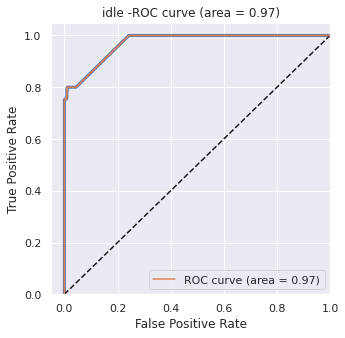

<Figure size 1080x360 with 0 Axes>

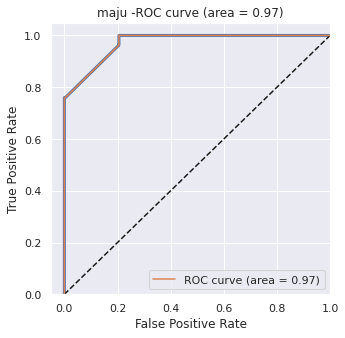

<Figure size 1080x360 with 0 Axes>

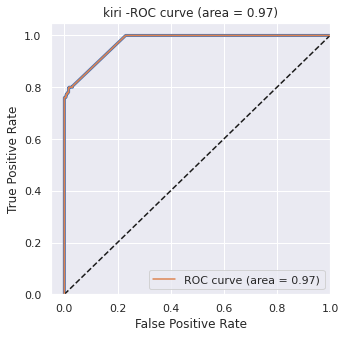

<Figure size 1080x360 with 0 Axes>

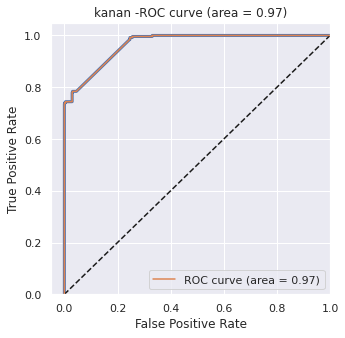

In [313]:
from sklearn.metrics import roc_curve, auc
#y_score = clf.decision_function(xval)
y_score = model.predict(test_X)

#Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    
    
print("roc_auc:",sum(roc_auc.values())/4)
ACTIONS =  ["idle","maju","kiri", "kanan"]
for i in range(0,4):
    plt.figure()
    fig, ax = plt.subplots(figsize=(5,5))
    plt.plot(fpr[i], tpr[i],linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    #plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % ACTIONS[i])
    plt.title('%s -ROC curve (area = %0.2f)' % (ACTIONS[i],roc_auc[i]))
    
    plt.legend(loc="lower right")
    plt.show()
    